# Algorithmic Trading COMP0051 2023/24 Coursework 2

#### 1. Time Series Prep [30 Points]

### (a)

In [34]:
import pandas as pd

# Load the data
sptl_df = pd.read_csv('SPTL.csv')
effr_df = pd.read_excel('EFFR_rates.xlsx')

# Convert EFFR annual rate to a daily rate assuming 252 trading days in a year
effr_df['Daily Rate'] = effr_df['Rate (%)'] / 100 / 252

# Process dates for merging
effr_df['Effective Date'] = pd.to_datetime(effr_df['Effective Date'])
effr_df.set_index('Effective Date', inplace=True)
sptl_df['Date'] = pd.to_datetime(sptl_df['Date'])
sptl_df.set_index('Date', inplace=True)

# Merge the datasets on the date index
merged_df = sptl_df.join(effr_df['Daily Rate'], how='left')
merged_df['Daily Rate'].fillna(method='ffill', inplace=True)

# Calculate the daily price change for SPTL
merged_df['Price Change'] = merged_df['Adj Close'].diff()

# Calculate the daily excess return per unit of SPTL
merged_df['Excess Return'] = merged_df['Price Change'] / merged_df['Adj Close'] - merged_df['Daily Rate']

merged_df.head(5)


c:\Users\lyakh\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\lyakh\AppData\Local\Temp\ipykernel_21460\710385673.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['Daily Rate'].fillna(method='ffill', inplace=True)


,Open,High,Low,Close,Adj Close,Volume,Daily Rate,Price Change,Excess Return
Date,,,,,,,,,
2014-01-02,29.924999,30.070000,29.924999,30.055,23.299057,25400,0.000003,NaN,NaN
2014-01-03,29.959999,30.105000,29.959999,30.035,23.283548,22000,0.000003,-0.015509,-0.000669
2014-01-06,30.110001,30.270000,30.110001,30.160,23.380453,3200,0.000003,0.096905,0.004142
2014-01-07,30.240000,30.260000,30.200001,30.260,23.457968,3800,0.000003,0.077515,0.003302
2014-01-08,30.075001,30.184999,30.075001,30.150,23.372698,14800,0.000003,-0.085270,-0.003651


### (b)

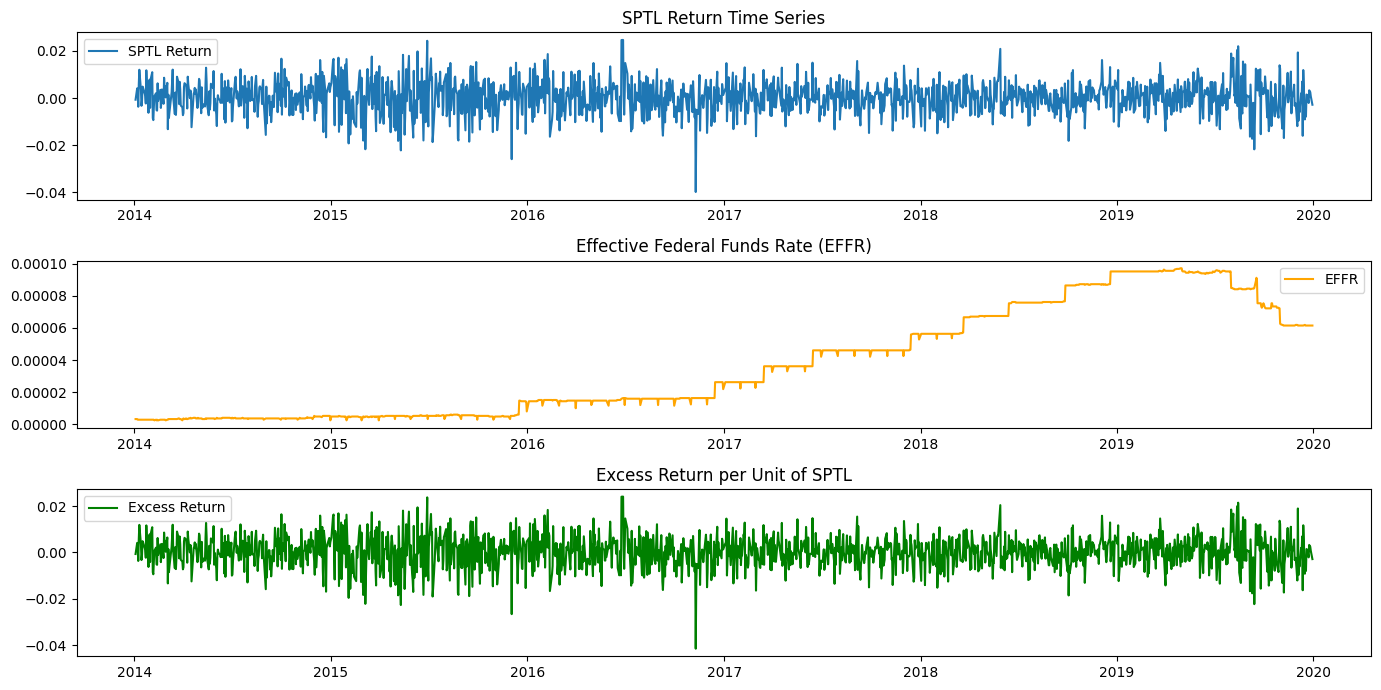

In [35]:
import matplotlib.pyplot as plt

# Calculate the daily return for SPTL
merged_df['SPTL Return'] = merged_df['Adj Close'].pct_change()

# Remove the NaN values for plotting
plot_df = merged_df.dropna(subset=['SPTL Return', 'Daily Rate', 'Excess Return'])

# Plotting
plt.figure(figsize=(14, 7))

# SPTL return time series
plt.subplot(3, 1, 1)
plt.plot(plot_df.index, plot_df['SPTL Return'], label='SPTL Return')
plt.title('SPTL Return Time Series')
plt.legend()

# EFFR time series
plt.subplot(3, 1, 2)
plt.plot(plot_df.index, plot_df['Daily Rate'], label='EFFR', color='orange')
plt.title('Effective Federal Funds Rate (EFFR)')
plt.legend()

# Excess return per unit of SPTL
plt.subplot(3, 1, 3)
plt.plot(plot_df.index, plot_df['Excess Return'], label='Excess Return', color='green')
plt.title('Excess Return per Unit of SPTL')
plt.legend()

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()


#### 2. Trading Strategies [45 Points]

### (a)

In [36]:
import pandas as pd
import numpy as np

# Define the leverage and initial capital
leverage = 10
initial_capital = 200000
total_book_size = initial_capital * leverage

# Define the moving average time window, for example, 20 days
time_window = 5

# Calculate the number of days for training (70% of the dataset)
train_days = int(len(merged_df) * 0.7)

# Split the dataset into training and test sets and make explicit copies
train_df = merged_df.iloc[:train_days].copy()
test_df = merged_df.iloc[train_days:].copy()

# Define the trend-following trading strategy with dynamic leverage utilization
def trend_following_strategy(row, initial_capital, leverage):
    if np.isnan(row['Moving_Average']):
        return 0
    distance_from_ma = abs(row['Adj Close'] - row['Moving_Average']) / row['Moving_Average']
    position_size = initial_capital * distance_from_ma * leverage
    if row['Moving_Average'] < row['Adj Close']:
        position = position_size
    elif row['Moving_Average'] > row['Adj Close']:
        position = -position_size
    else:
        position = 0
    return position

# Define the mean reversion trading strategy with dynamic leverage utilization
def mean_reversion_strategy(row, initial_capital, leverage):
    if np.isnan(row['Moving_Average']):
        return 0
    distance_from_ma = abs(row['Adj Close'] - row['Moving_Average']) / row['Moving_Average']
    position_size = initial_capital * distance_from_ma * leverage
    if row['Adj Close'] < row['Moving_Average']:
        position = position_size
    elif row['Adj Close'] > row['Moving_Average']:
        position = -position_size
    else:
        position = 0
    return position

# Define the AR trading strategy
def ar_strategy(row, initial_capital, leverage, time_window):
    if np.isnan(row['AR_Prediction']):
        return 0
    predicted_next_value = row['AR_Prediction']
    distance_from_prediction = abs(row['Adj Close'] - predicted_next_value) / predicted_next_value
    position_size = initial_capital * distance_from_prediction * leverage
    if predicted_next_value > row['Adj Close']:
        position = position_size
    elif predicted_next_value < row['Adj Close']:
        position = -position_size
    else:
        position = 0
    return position

# Calculate the moving average for the 'Adj Close' prices
train_df['Moving_Average'] = train_df['Adj Close'].rolling(window=time_window).mean().shift(1)
test_df['Moving_Average'] = test_df['Adj Close'].rolling(window=time_window).mean().shift(1)

# Calculate AR predictions (rolling mean as a simple prediction)
train_df['AR_Prediction'] = train_df['Adj Close'].rolling(window=time_window).mean().shift(1)
test_df['AR_Prediction'] = test_df['Adj Close'].rolling(window=time_window).mean().shift(1)

# Apply the strategies to both training and test sets
for df in [train_df, test_df]:
    df['Trend_Following_Strategy'] = df.apply(trend_following_strategy, axis=1, initial_capital=initial_capital, leverage=leverage)
    df['Trend_Following_PnL'] = (df['Adj Close'].diff() - df['Daily Rate']) * df['Trend_Following_Strategy']
    
    df['Mean_Reversion_Strategy'] = df.apply(mean_reversion_strategy, axis=1, initial_capital=initial_capital, leverage=leverage)
    df['Mean_Reversion_PnL'] = (df['Adj Close'].diff() - df['Daily Rate']) * df['Mean_Reversion_Strategy']
    
    df['AR_Strategy'] = df.apply(ar_strategy, axis=1, initial_capital=initial_capital, leverage=leverage, time_window=time_window)
    df['AR_PnL'] = (df['Adj Close'].diff() - df['Daily Rate']) * df['AR_Strategy']

# Output the head of the training and test set to verify
print(train_df[['Adj Close', 'Moving_Average', 'Trend_Following_Strategy', 'Trend_Following_PnL', 
                'Mean_Reversion_Strategy', 'Mean_Reversion_PnL', 'AR_Strategy', 'AR_PnL']].tail())
print(test_df[['Adj Close', 'Moving_Average', 'Trend_Following_Strategy', 'Trend_Following_PnL', 
               'Mean_Reversion_Strategy', 'Mean_Reversion_PnL', 'AR_Strategy', 'AR_PnL']].tail())


            Adj Close  Moving_Average  Trend_Following_Strategy  \
Date                                                              
2018-03-07  29.410709       29.512756              -6915.423377   
2018-03-08  29.575012       29.486816               5982.090518   
2018-03-09  29.393423       29.453951              -4110.022427   
2018-03-12  29.575012       29.440116               9164.067028   
2018-03-13  29.713385       29.476434              16077.304222   

            Trend_Following_PnL  Mean_Reversion_Strategy  Mean_Reversion_PnL  \
Date                                                                           
2018-03-07           120.067996              6915.423377         -120.067996   
2018-03-08           982.538332             -5982.090518         -982.538332   
2018-03-09           746.566459              4110.022427         -746.566459   
2018-03-12          1663.577380             -9164.067028        -1663.577380   
2018-03-13          2223.758874            -16077.

### (b)

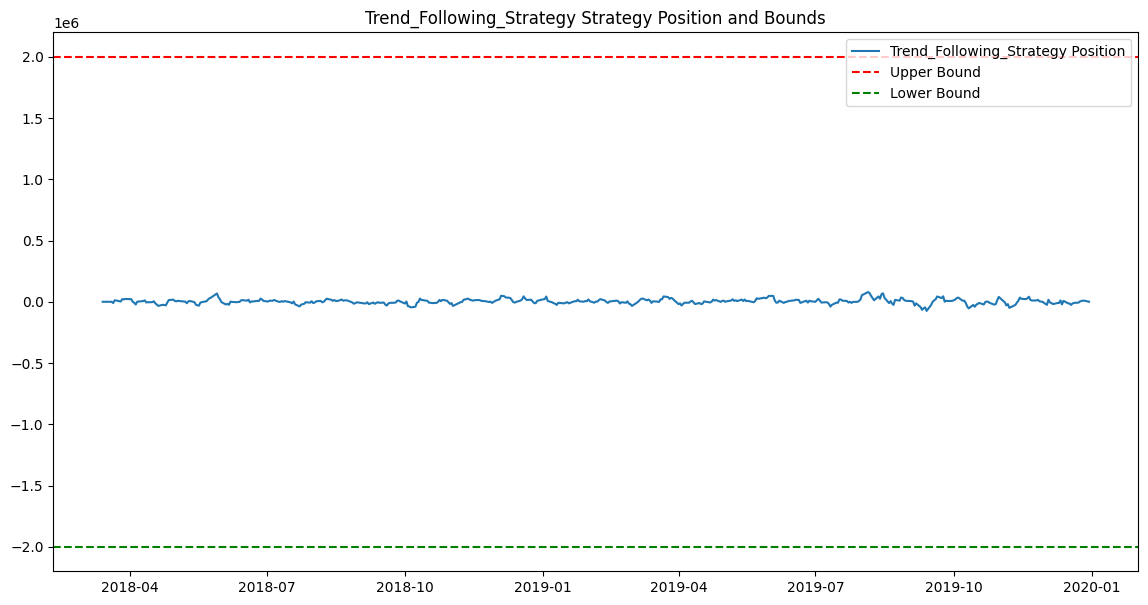

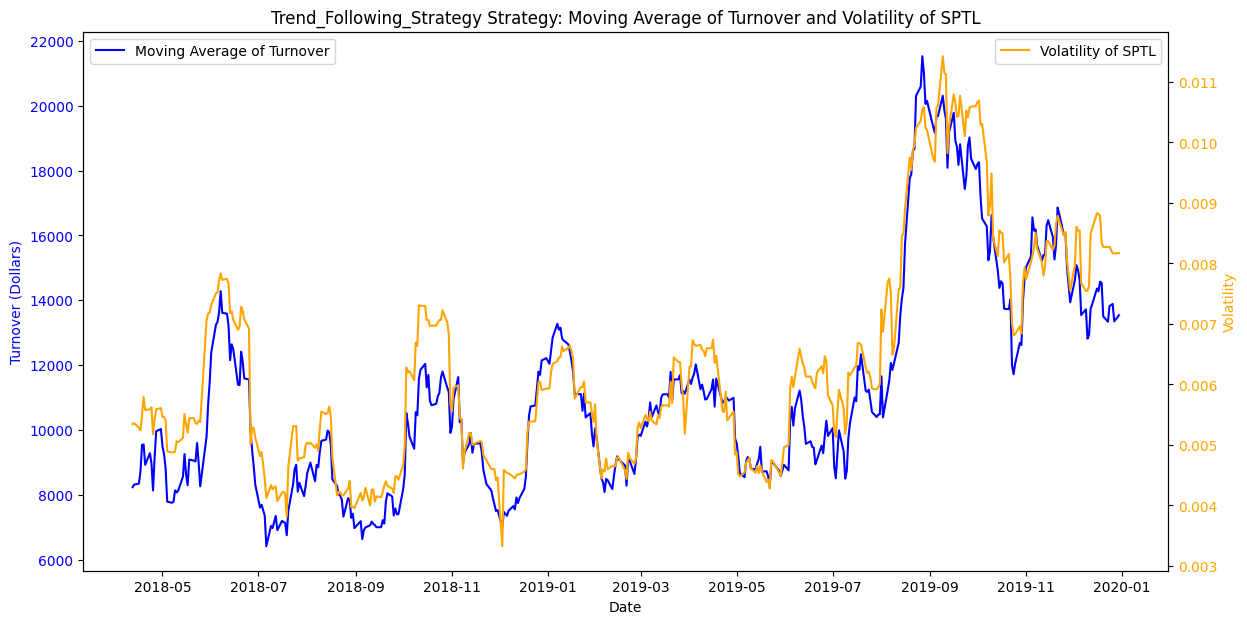

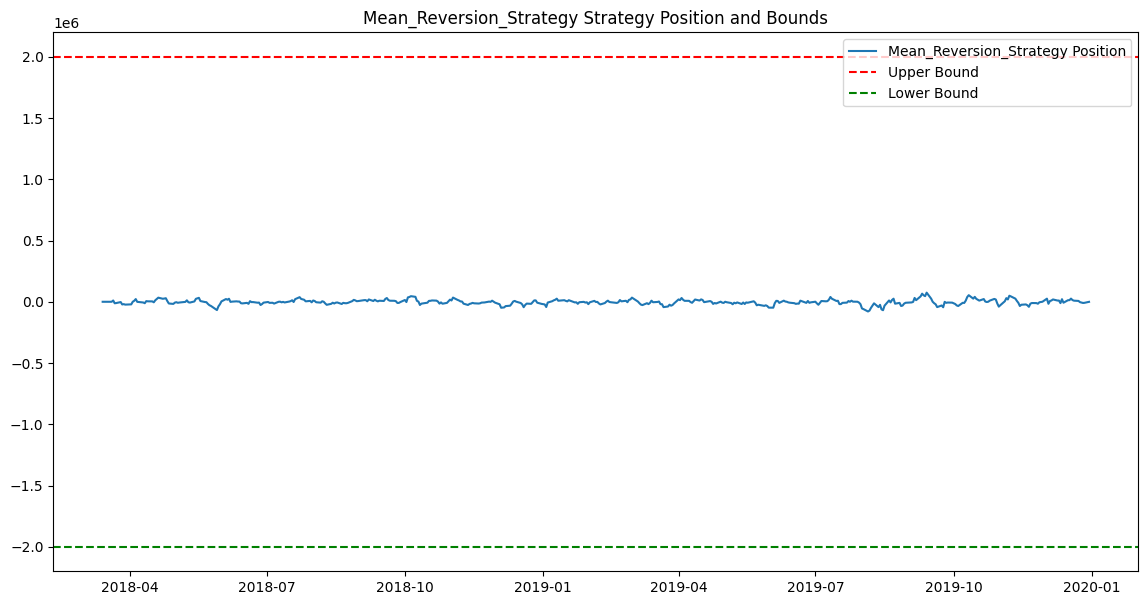

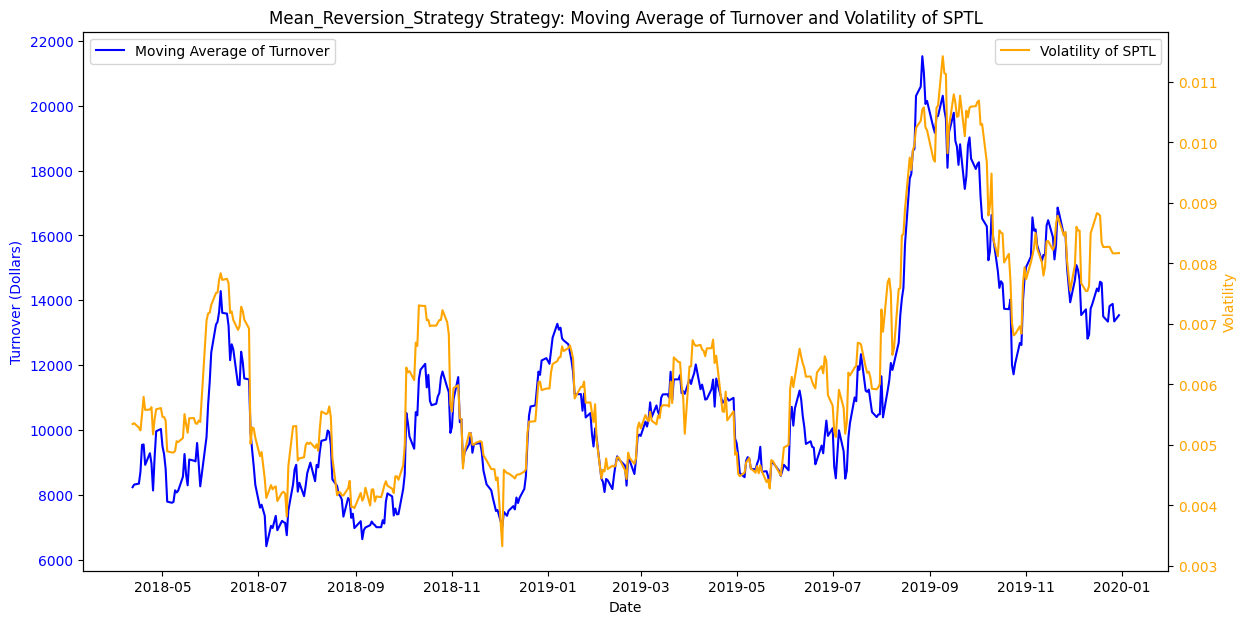

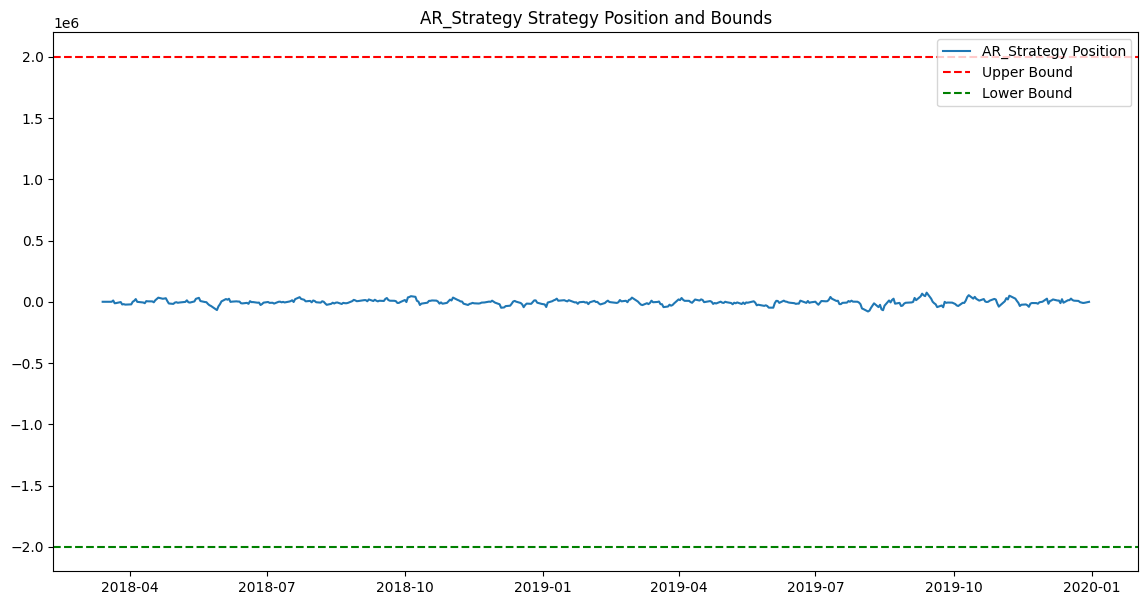

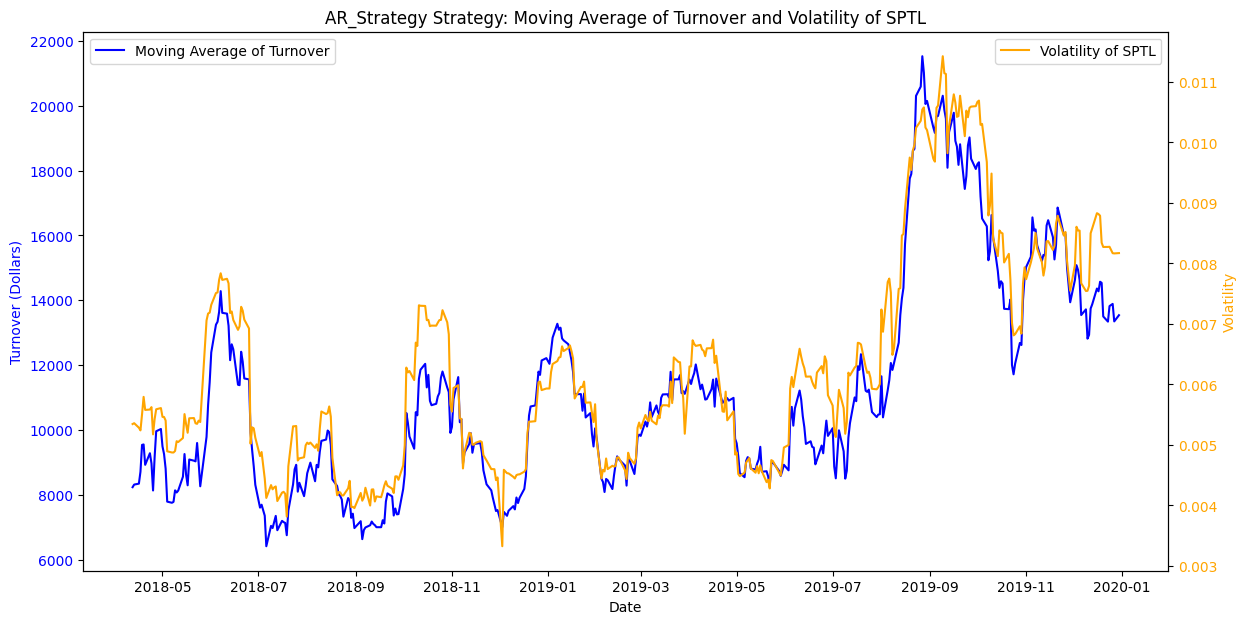

In [37]:
# Assuming train_df already contains the columns for each strategy's positions

# Define a function to calculate and plot metrics for a given strategy
def calculate_and_plot_strategy_metrics(df, strategy_name, initial_capital, leverage):
    # Calculate turnover in dollar value and in units for the given strategy
    df[strategy_name + '_Turnover_dollars'] = df[strategy_name].diff().abs()
    df[strategy_name + '_Turnover_units'] = (df[strategy_name] / df['Adj Close']).diff().abs()

    # Calculate moving average of the turnover in dollars
    df[strategy_name + '_Turnover_MA'] = df[strategy_name + '_Turnover_dollars'].rolling(window=20).mean()

    # Calculate the volatility of SPTL (standard deviation of returns)
    df['Volatility'] = df['Adj Close'].pct_change().rolling(window=20).std()

    # Plot the strategy position with upper and lower bounds
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df[strategy_name], label=strategy_name + ' Position')
    plt.axhline(y=leverage * initial_capital, color='r', linestyle='--', label='Upper Bound')
    plt.axhline(y=-leverage * initial_capital, color='g', linestyle='--', label='Lower Bound')
    plt.title(strategy_name + ' Strategy Position and Bounds')
    plt.legend()
    plt.show()

    # Plot turnover moving average and volatility
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Turnover in Dollars with Moving Average
    ax1.plot(df.index, df[strategy_name + '_Turnover_MA'], label='Moving Average of Turnover', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Turnover (Dollars)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()

    # Volatility
    ax2.plot(df.index, df['Volatility'], label='Volatility of SPTL', color='orange')
    ax2.set_ylabel('Volatility', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.legend(loc='upper right')

    plt.title(strategy_name + ' Strategy: Moving Average of Turnover and Volatility of SPTL')
    plt.show()

# Call the function for each strategy
calculate_and_plot_strategy_metrics(test_df, 'Trend_Following_Strategy', initial_capital, leverage)
calculate_and_plot_strategy_metrics(test_df, 'Mean_Reversion_Strategy', initial_capital, leverage)
calculate_and_plot_strategy_metrics(test_df, 'AR_Strategy', initial_capital, leverage)


### (C)

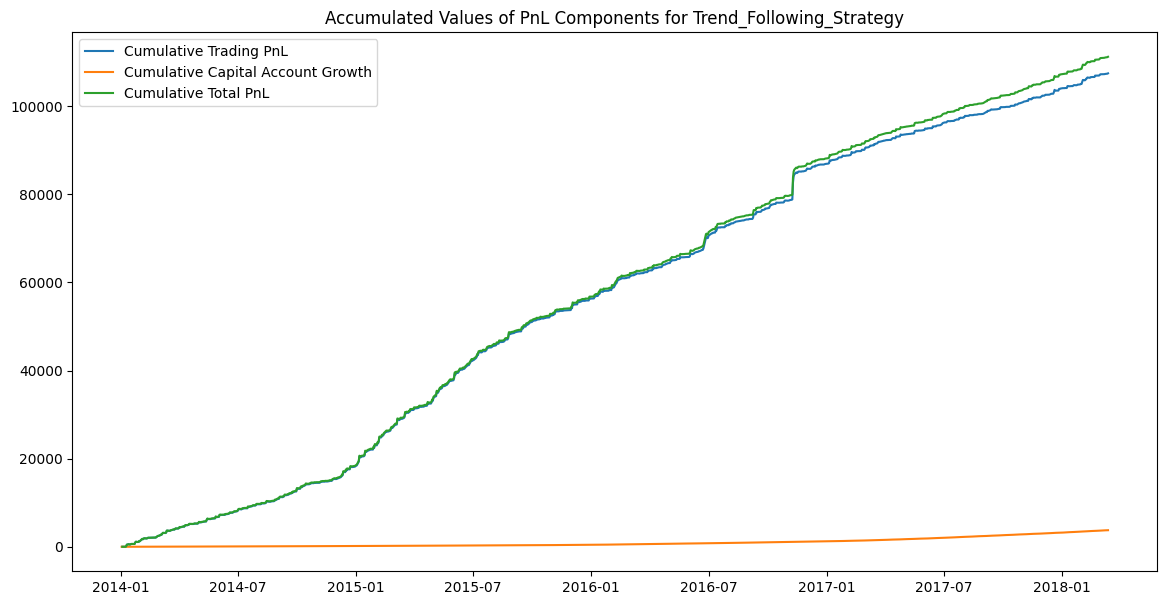

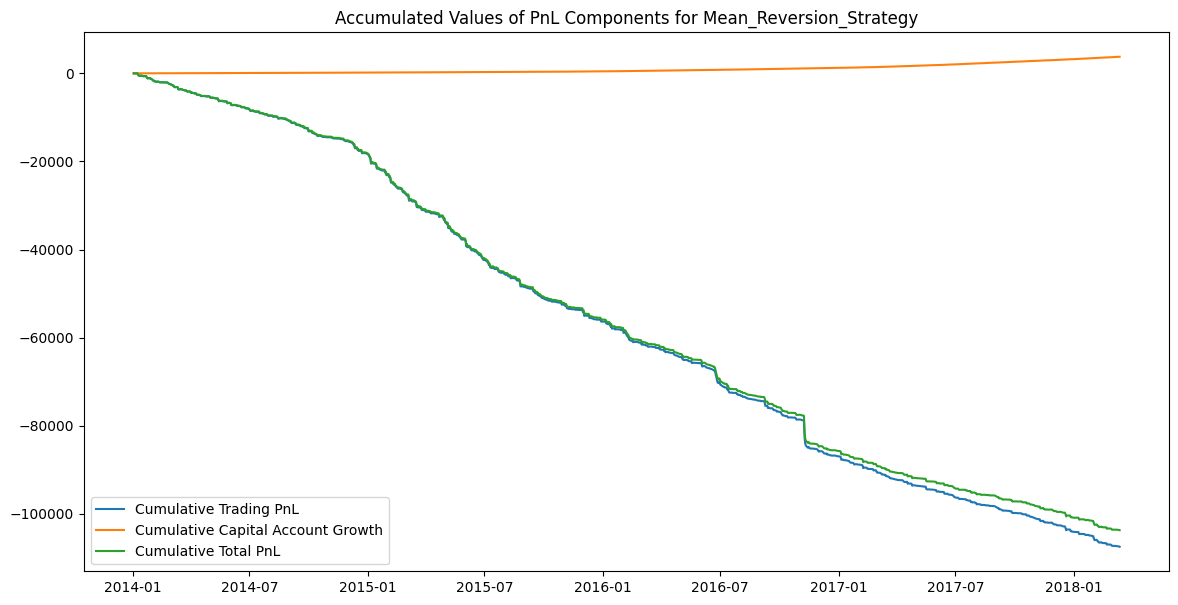

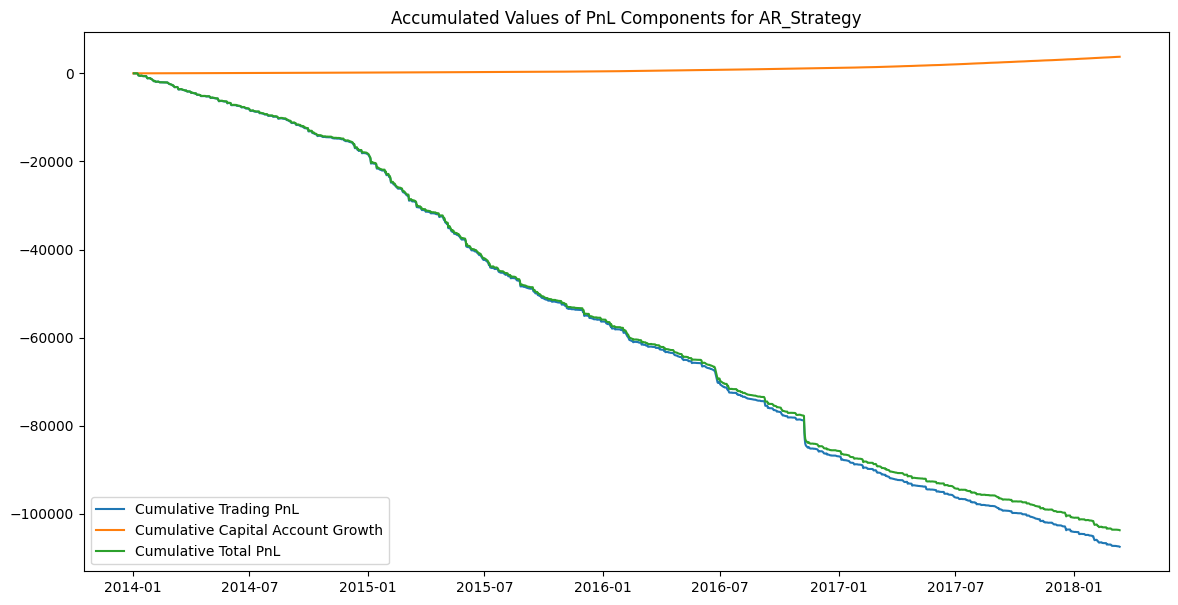

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Constants
initial_capital = 200000  # initial capital
leverage = 10             # leverage

# Define a function to calculate and plot PnL for a given strategy
def calculate_and_plot_pnl(strategy_name):
    # Calculate Mt, which is the total margin used at time t
    train_df[strategy_name + '_Mt'] = train_df[strategy_name].abs() / leverage

    # Calculate the trading PnL (Delta Vt)
    train_df[strategy_name + '_Delta_Vt'] = (train_df['Adj Close'].diff() - train_df['Daily Rate']) * (train_df[strategy_name] / train_df['Adj Close'])

    # Calculate the change in the growth of the money-market capital account (Delta Vcap)
    train_df[strategy_name + '_Delta_Vcap'] = (initial_capital - train_df[strategy_name + '_Mt']) * train_df['Daily Rate']

    # Calculate the total PnL (Delta Vtotal)
    train_df[strategy_name + '_Delta_Vtotal'] = train_df[strategy_name + '_Delta_Vt'] + train_df[strategy_name + '_Delta_Vcap']

    # Calculate the cumulative PnL
    train_df[strategy_name + '_Cumulative_Delta_Vt'] = train_df[strategy_name + '_Delta_Vt'].cumsum()
    train_df[strategy_name + '_Cumulative_Delta_Vcap'] = train_df[strategy_name + '_Delta_Vcap'].cumsum()
    train_df[strategy_name + '_Cumulative_Delta_Vtotal'] = train_df[strategy_name + '_Delta_Vtotal'].cumsum()

    # Plotting the accumulated values
    plt.figure(figsize=(14, 7))
    plt.plot(train_df.index, train_df[strategy_name + '_Cumulative_Delta_Vt'], label='Cumulative Trading PnL')
    plt.plot(train_df.index, train_df[strategy_name + '_Cumulative_Delta_Vcap'], label='Cumulative Capital Account Growth')
    plt.plot(train_df.index, train_df[strategy_name + '_Cumulative_Delta_Vtotal'], label='Cumulative Total PnL')
    plt.title(f'Accumulated Values of PnL Components for {strategy_name}')
    plt.legend()
    plt.show()

# Run calculations and plots for each strategy
for strategy in ['Trend_Following_Strategy', 'Mean_Reversion_Strategy', 'AR_Strategy']:
    calculate_and_plot_pnl(strategy)


### 3. Performance Indicators [25 Points]

### (a) 

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Define the functions to calculate each of the performance metrics
def calculate_metrics(df, strategy_name):
    # Daily returns and excess returns
    df[strategy_name + '_Daily_Return'] = df[strategy_name + '_PnL'] / initial_capital
    df[strategy_name + '_Excess_Return'] = df[strategy_name + '_Daily_Return'] - df['Daily Rate']

    # Sharpe Ratio
    sharpe_ratio = df[strategy_name + '_Excess_Return'].mean() / df[strategy_name + '_Excess_Return'].std()
    
    # Sortino Ratio
    negative_returns = df[strategy_name + '_Excess_Return'][df[strategy_name + '_Excess_Return'] < 0]
    sortino_ratio = df[strategy_name + '_Excess_Return'].mean() / negative_returns.std() if negative_returns.std() != 0 else np.nan

    # Maximum Drawdown
    cumulative_returns = (1 + df[strategy_name + '_Excess_Return']).cumprod()
    max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()

    # Calmar Ratio
    annualized_return = df[strategy_name + '_Excess_Return'].mean() * 252
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

    return sharpe_ratio, sortino_ratio, max_drawdown, calmar_ratio

# Calculate and print the performance metrics for each strategy on both datasets
for strategy in ['Trend_Following', 'Mean_Reversion', 'AR']:
    train_sharpe, train_sortino, train_max_dd, train_calmar = calculate_metrics(train_df, strategy)
    test_sharpe, test_sortino, test_max_dd, test_calmar = calculate_metrics(test_df, strategy)
    
    print(f"{strategy} Strategy Metrics:")
    print(f"Training Set: Sharpe Ratio: {train_sharpe}, Sortino Ratio: {train_sortino}, Maximum Drawdown: {train_max_dd}, Calmar Ratio: {train_calmar}")
    print(f"Test Set: Sharpe Ratio: {test_sharpe}, Sortino Ratio: {test_sortino}, Maximum Drawdown: {test_max_dd}, Calmar Ratio: {test_calmar}\n")


Trend_Following Strategy Metrics:
Training Set: Sharpe Ratio: 0.4548617375940087, Sortino Ratio: 2.6470209467310606, Maximum Drawdown: 58863.42808153853, Calmar Ratio: 6.404144743913505e-05
Test Set: Sharpe Ratio: 0.4169970332711411, Sortino Ratio: 1.8216983756163445, Maximum Drawdown: 9.586922951135477, Calmar Ratio: 0.39873697148305315

Mean_Reversion Strategy Metrics:
Training Set: Sharpe Ratio: -0.4559862554366635, Sortino Ratio: -0.4197149734423325, Maximum Drawdown: 0.9999967678808399, Calmar Ratio: -3.7787595006309065
Test Set: Sharpe Ratio: -0.4215000883118403, Sortino Ratio: -0.38862659759329227, Maximum Drawdown: 1.0008993856208164, Calmar Ratio: -3.8604076547906

AR Strategy Metrics:
Training Set: Sharpe Ratio: -0.4559862554366635, Sortino Ratio: -0.4197149734423325, Maximum Drawdown: 0.9999967678808399, Calmar Ratio: -3.7787595006309065
Test Set: Sharpe Ratio: -0.4215000883118403, Sortino Ratio: -0.38862659759329227, Maximum Drawdown: 1.0008993856208164, Calmar Ratio: -3.86

### (b)

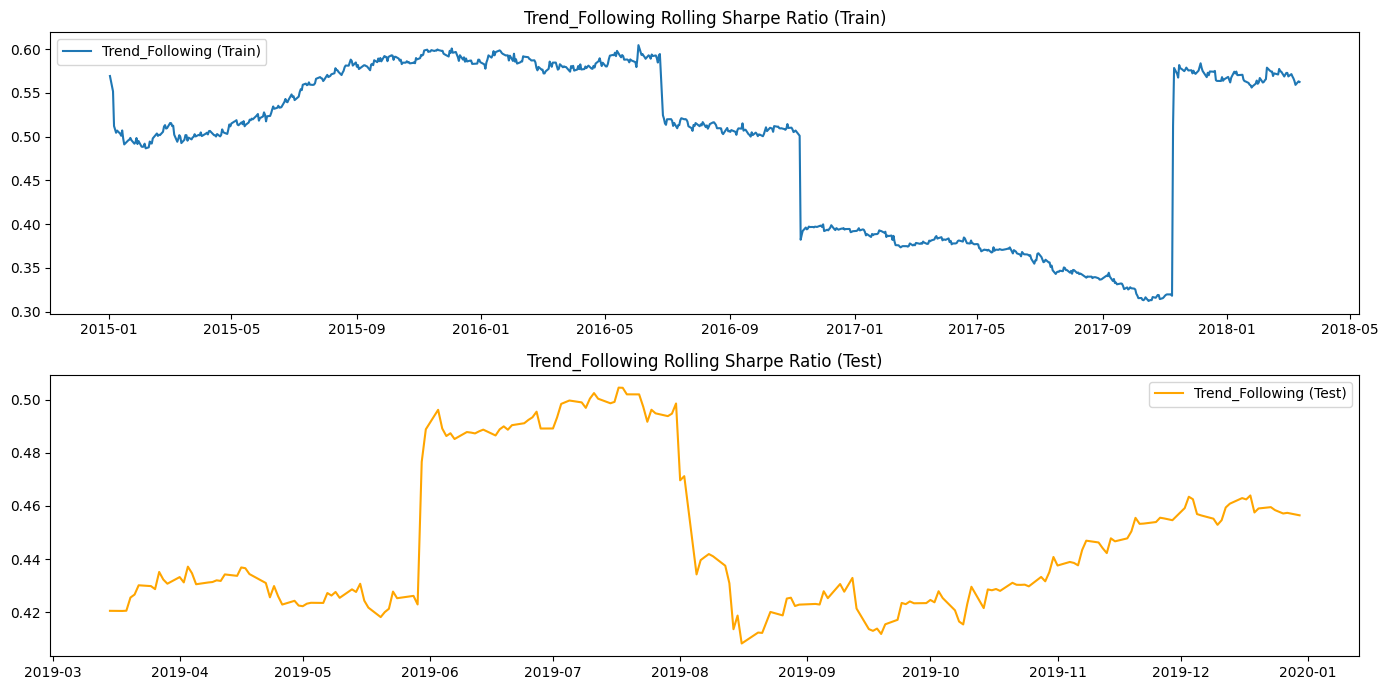

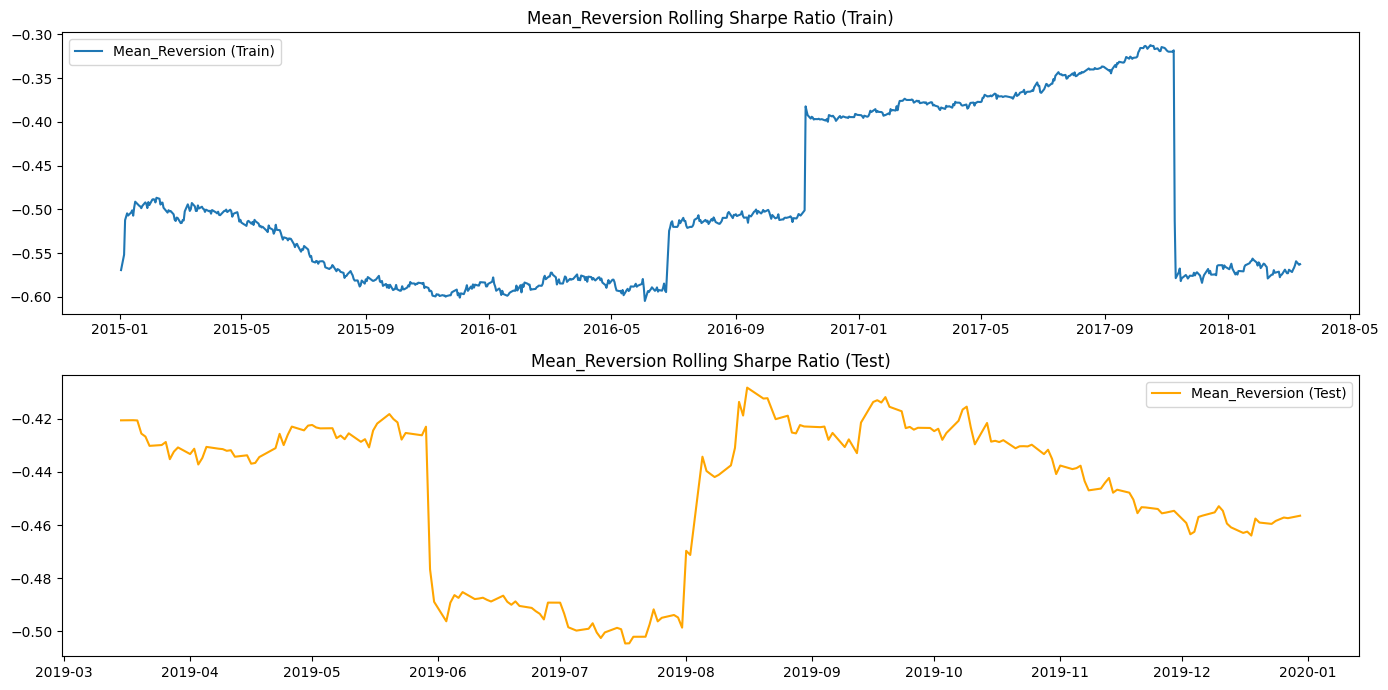

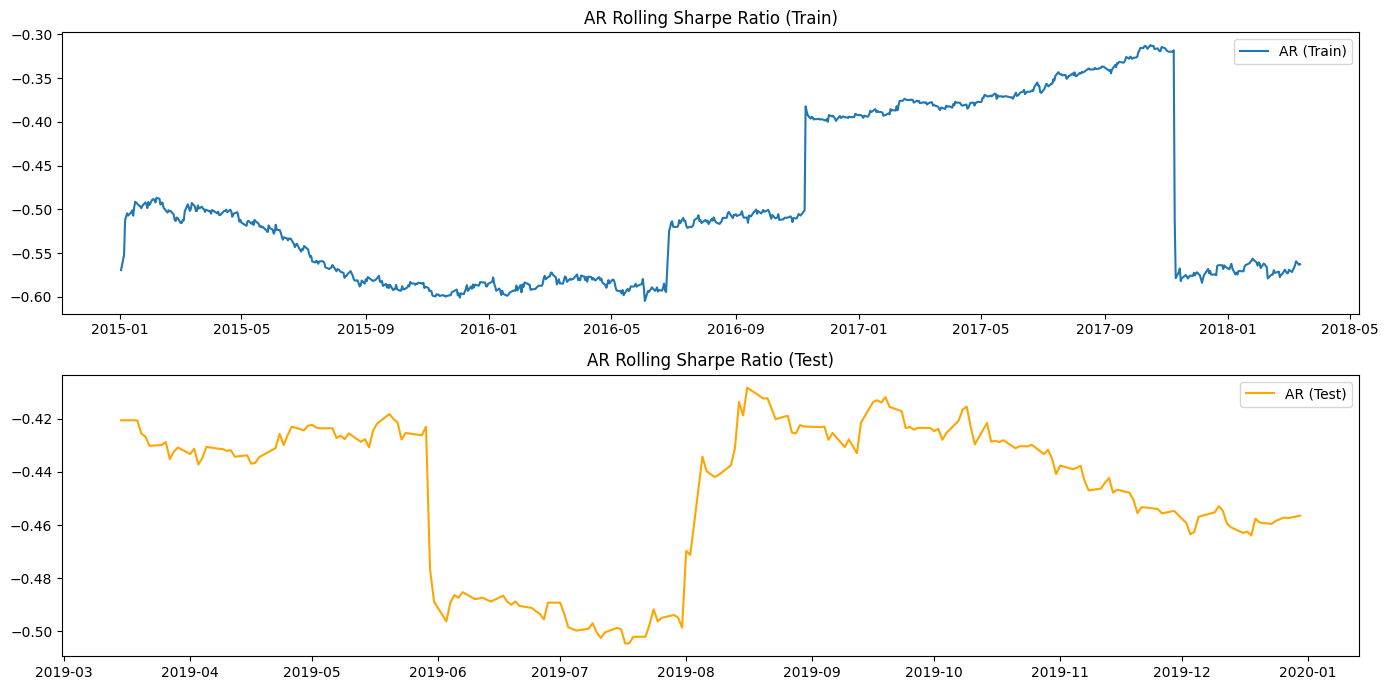

In [40]:
def calculate_rolling_sharpe_ratio(returns, risk_free_rate, rolling_window=252):
    # Excess returns
    excess_returns = returns - risk_free_rate
    # Rolling mean of excess returns
    rolling_mean = excess_returns.rolling(rolling_window).mean()
    # Rolling standard deviation of excess returns
    rolling_std = excess_returns.rolling(rolling_window).std()
    
    # Avoid division by zero
    rolling_std[rolling_std == 0] = np.nan
    
    # Rolling Sharpe Ratio
    rolling_sharpe_ratio = rolling_mean / rolling_std
    return rolling_sharpe_ratio

# Define the rolling window for a year of trading days
rolling_window = 252

# Plot the rolling Sharpe ratio for each strategy
strategies = ['Trend_Following', 'Mean_Reversion', 'AR']
for strategy in strategies:
    # We assume that '_PnL' columns for each strategy have been already calculated
    train_df[strategy + '_Daily_Returns'] = train_df[strategy + '_PnL'] / initial_capital
    test_df[strategy + '_Daily_Returns'] = test_df[strategy + '_PnL'] / initial_capital

    # Daily risk-free rate column 'Daily Rate' should be in decimal format
    train_df['Daily_Risk_Free_Rate'] = train_df['Daily Rate'] / 100
    test_df['Daily_Risk_Free_Rate'] = test_df['Daily Rate'] / 100

    # Calculate rolling Sharpe ratio
    train_df[strategy + '_Rolling_Sharpe'] = calculate_rolling_sharpe_ratio(
        train_df[strategy + '_Daily_Returns'], train_df['Daily_Risk_Free_Rate'], rolling_window)
    test_df[strategy + '_Rolling_Sharpe'] = calculate_rolling_sharpe_ratio(
        test_df[strategy + '_Daily_Returns'], test_df['Daily_Risk_Free_Rate'], rolling_window)

    # Plot the rolling Sharpe ratio
    plt.figure(figsize=(14, 7))
    
    # Training set rolling Sharpe ratio
    plt.subplot(2, 1, 1)
    plt.plot(train_df.index, train_df[strategy + '_Rolling_Sharpe'], label=f'{strategy} (Train)')
    plt.title(f'{strategy} Rolling Sharpe Ratio (Train)')
    plt.legend()

    # Test set rolling Sharpe ratio
    plt.subplot(2, 1, 2)
    plt.plot(test_df.index, test_df[strategy + '_Rolling_Sharpe'], label=f'{strategy} (Test)', color='orange')
    plt.title(f'{strategy} Rolling Sharpe Ratio (Test)')
    plt.legend()

    plt.tight_layout()
    plt.show()

### (c)

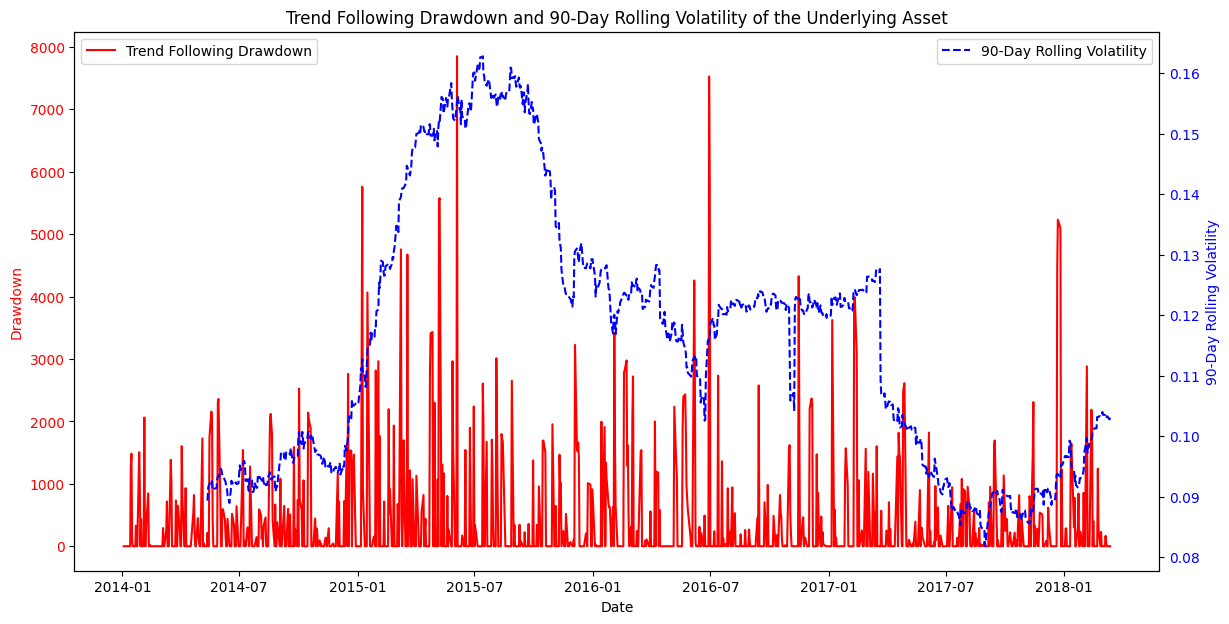

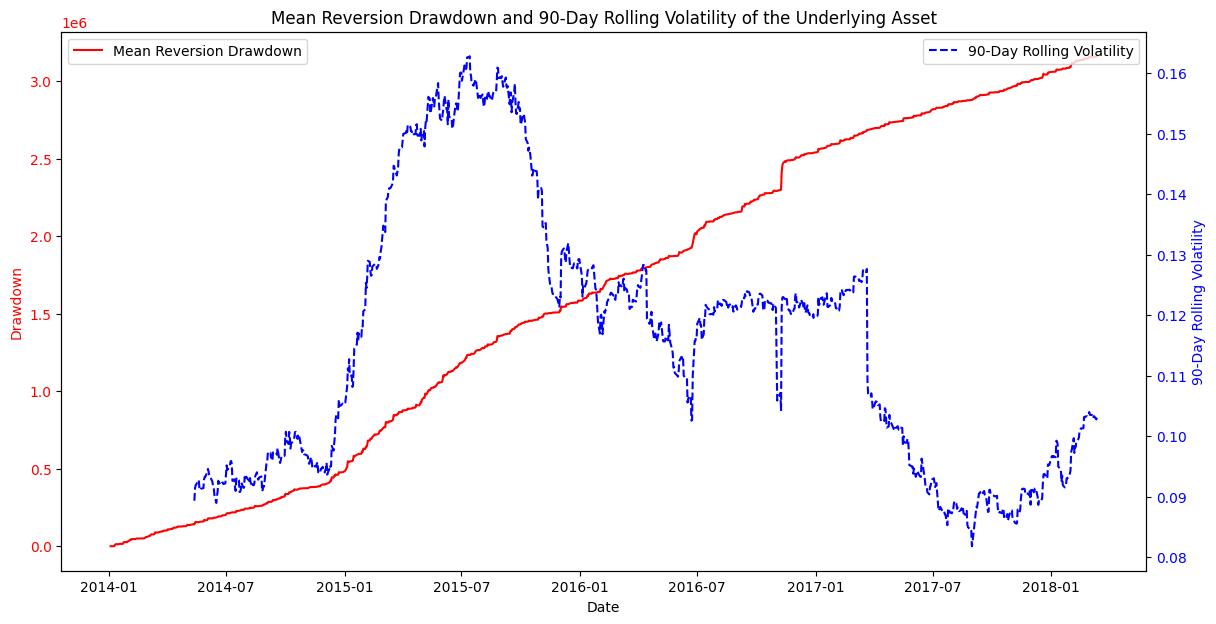

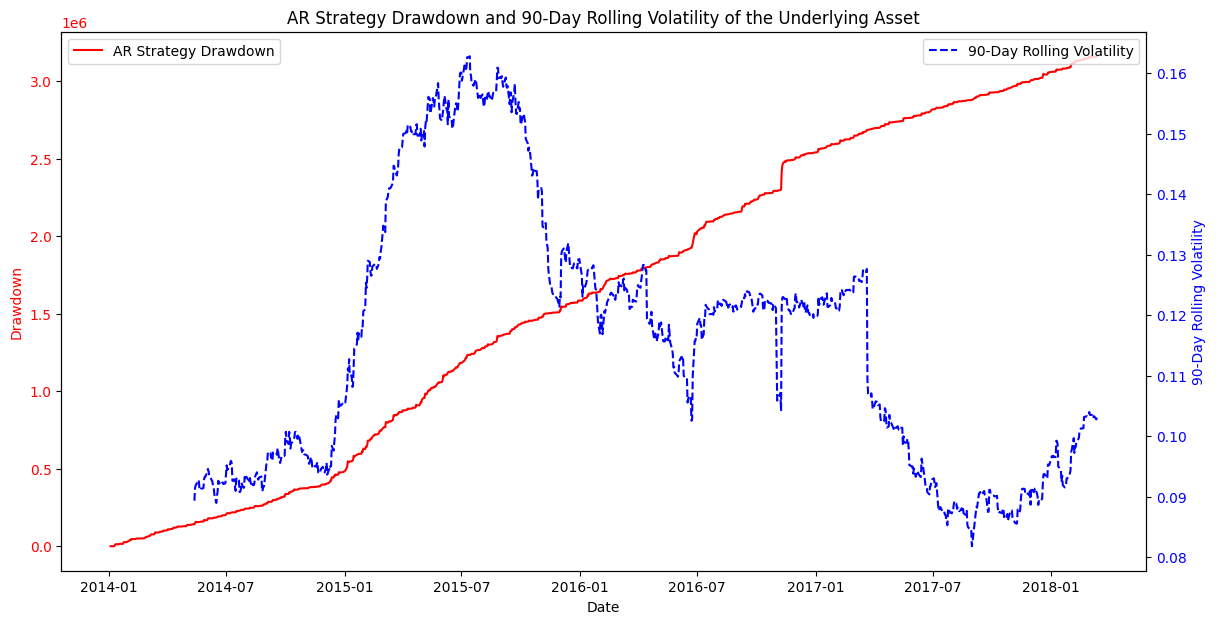

In [42]:
# Define a function to calculate drawdown and rolling volatility
def calculate_drawdown_rolling_volatility(df, pnl_column):
    # Calculate the cumulative PnL for the strategy
    df['Cumulative_' + pnl_column] = df[pnl_column].cumsum()

    # Calculate the running maximum
    df['Running_Max_' + pnl_column] = df['Cumulative_' + pnl_column].cummax()

    # Calculate drawdown
    df['Drawdown_' + pnl_column] = df['Running_Max_' + pnl_column] - df['Cumulative_' + pnl_column]

    # Calculate the rolling 90-day volatility of the underlying asset
    volatility_window = 90  # Adjust the window size if needed
    df['Rolling_Volatility'] = df['Adj Close'].pct_change().rolling(volatility_window).std() * np.sqrt(252)

# Plot the drawdown and rolling volatility for each strategy
def plot_drawdown_rolling_volatility(df, pnl_column, strategy_name):
    calculate_drawdown_rolling_volatility(df, pnl_column)
    
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Drawdown plot
    ax1.plot(df.index, df['Drawdown_' + pnl_column], label=strategy_name + ' Drawdown', color='red')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Drawdown', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc='upper left')

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()

    # Rolling volatility plot
    ax2.plot(df.index, df['Rolling_Volatility'], label='90-Day Rolling Volatility', color='blue', linestyle='--')
    ax2.set_ylabel('90-Day Rolling Volatility', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend(loc='upper right')

    plt.title(f'{strategy_name} Drawdown and 90-Day Rolling Volatility of the Underlying Asset')
    plt.show()

# Apply the function for each strategy's PnL'Trend_Following', 'Mean_Reversion', 'AR'
plot_drawdown_rolling_volatility(train_df, 'Trend_Following_PnL', 'Trend Following')
plot_drawdown_rolling_volatility(train_df, 'Mean_Reversion_PnL', 'Mean Reversion')
plot_drawdown_rolling_volatility(train_df, 'AR_PnL', 'AR Strategy')